# **Misogyny Recognition Model using BERT**





> What is transfer learning?

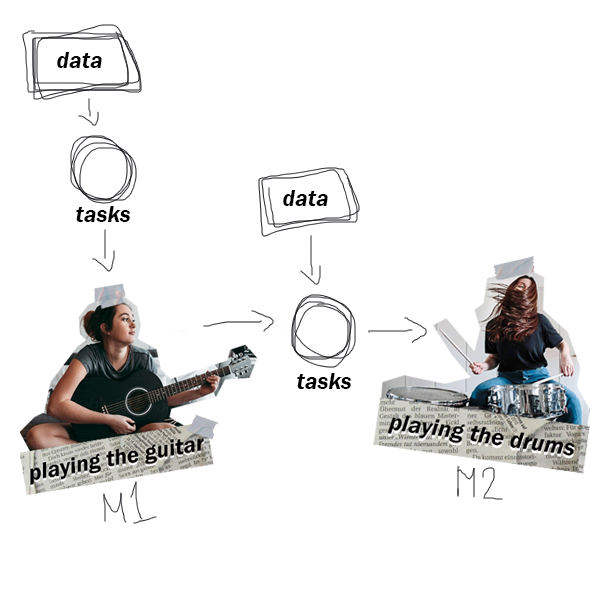



It's a machine learning task where knowledge from a previous model is used as a starting point in tasks to generate another model. Where:


*   **Model (M1, M2).** File that has been trained to recognize certain types of patterns.
*   **Tasks.** "Things" to do in order to construct a machine learning structure to generate a model.
*   **Data.** Main resource of the whole process, it's where the knowledge is extracted from.



> What is BERT?

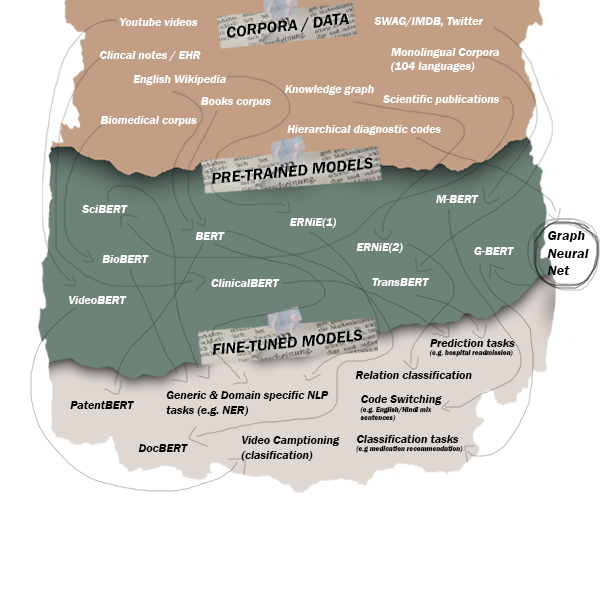



Source extracted from [here](https://towardsdatascience.com/a-review-of-bert-based-models-4ffdc0f15d58).

**BERT** stands for **B**idirectional **E**ncoder **R**epresentations from **T**ransformers. 

*   It's based on the Transformer architecture.
*   It's a “deep bidirectional” model. Bidirectional means that BERT learns information from both the left and the right side of a token’s context during the training phase.
*   It's pre-trained on a large corpus of unlabelled text including the entire Wikipedia and Book Corpus.

> "BERT is designed to pretrain deep bidirectional representations from
unlabeled text by jointly conditioning on both
left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer
to create state-of-the-art models for a wide
range of tasks, such as question answering and
language inference, without substantial task-specific architecture modifications." [[1]](https://arxiv.org/pdf/1810.04805.pdf)


**BERT for classification**

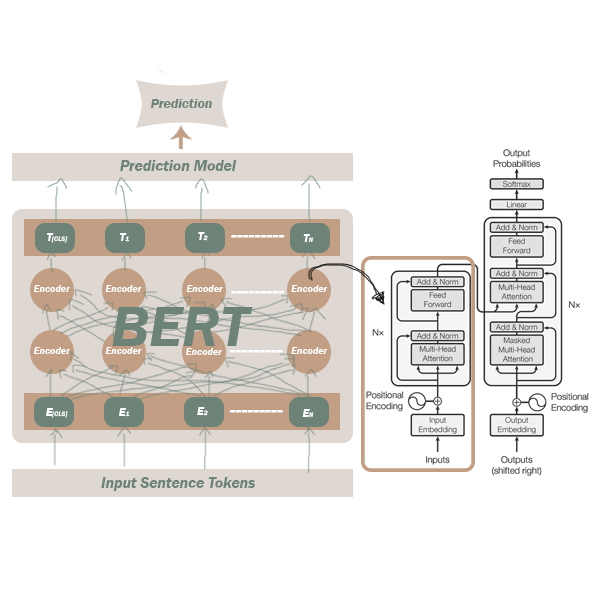

In this work, we use BERT for feature extraction, in order to train a classification model using the embeddings it generates from its pre-trained process.

**Libraries**
---


In [ ]:
import numpy as np
import pandas as pd
import torch
!pip install transformers
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import time
import matplotlib.pylab as plt

**Loading Dataset**
---


In [ ]:
#from drive
def load_data(file_name,delimiter):
  from google.colab import drive
  import random
  drive.mount('/content/drive')
  df = pd.read_csv('/content/drive/My Drive/Misogyny BERT sources/'+file_name, encoding="utf-8", names=['Text','Label'], delimiter=delimiter, header=None)
  return df

In [ ]:
df = load_data('20210629_semeval.csv',',')

In [ ]:
s=df.sample(frac=0.3, replace=False, random_state=1)
df=pd.DataFrame(s,columns=list(df.columns))
df.head()

**Create instances of DistilBERT or base BERT model and BERT tokenizer**
---

Check:


1.   Paper: https://arxiv.org/abs/1910.01108
2.   API: https://huggingface.co/transformers/model_doc/distilbert.html
3.   Multilingual model (https://huggingface.co/distilbert-base-multilingual-cased) trained on the concatenation of Wikipedia in 104 different languages (including Spanish). The model has 6 layers, 768 dimensions.





In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-multilingual-cased')
## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-multilingual-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)
type(model)

**Run BERT for extraction features**
---
The model() function propagates the sentences through BERT. The results of this processing will be returned into last_hidden_states.
We are interested in the last level of the states (last layer) which can be obtained as:

*last_hidden_states[0]* 

This is a tensor of three order of the form [NumberOfSentences, Length, Dim_Embedding].

From this tensor, we can focus on the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of every sentence. The output corresponding to **that token can be thought of as an embedding for the entire sentence**.

In order to get the input sentences for bert in the format that it requires we must consider:

*   **Tokenization.** Based on the trained model, the input dataset can be tokenized. This process is applied for each document (sentence) in the dataset. 
*   **Padding.** So far, we have lists of tokens of different length. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).
*   **Masking.** One of the main characteristics of the process BERT does is the attention that is included when processing the input. This attention comes from the transforme architecture and it allows BERT to focus in the entire sentence. Due to this, it's important to tell BERT which part of the whole padded vector contains the information, generating a vector filled up with 1s when the token has information and the ones that are empty are 0s.





In [ ]:
class BERTFeatureExtraction():

  def __init__(self, data, model, tokenizer, max_len):
    self.data = data
    self.model = model
    self.tokenizer = tokenizer
    self.max_len = max_len
    #self.start_feature_extraction()

  def start_feature_extraction(self):
    # Tokenizing, padding and masking 
    tokenized = self.tokenization()
    padded = self.padding(tokenized)
    attention_mask = self.masking(padded)
    
    # Getting the tensors for the padded data and the attention mask
    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    
    # Setting the output layer of the model
    with torch.no_grad():
      last_hidden_states = self.model(input_ids, attention_mask=attention_mask)
    
    # Getting the extracted features from the 3D representation
    features = last_hidden_states[0][:,0,:].numpy()

    #Getting the labels
    labels = self.data['Label']

    return features,labels

  #1 - Tokenization
  def tokenization(self):
    tokenized = self.data['Text'].apply((lambda x: self.tokenizer.encode(x, add_special_tokens=True)))
    return tokenized

  #2 - Padding
  def padding(self, tokenized):
    #Determine the length of the largest tokenized list if you'll generate a new embeddings dataset to train a new model 
    self.max_len = 0 
    for i in tokenized.values:
        if len(i) > self.max_len:
            self.max_len = len(i)
    # Padding all tokenized list
    padded = np.array([i + [0]*(self.max_len-len(i)) for i in tokenized.values])
    return padded

  #3 - Masking
  def masking(self, padded):
    attention_mask = np.where(padded != 0, 1, 0)
    return attention_mask
  



In [ ]:
ob_training = BERTFeatureExtraction(df,model,tokenizer,0)
features, labels = ob_training.start_feature_extraction()

In [ ]:
dir = '/content/drive/My Drive/Misogyny BERT sources/'
mname = "Extractor Model"+"-"+time.strftime("%Y%m%d-%H%M%S")
torch.save(model,dir+mname)
mname = "Tokenizer Model"+"-"+time.strftime("%Y%m%d-%H%M%S")
torch.save(tokenizer,dir+mname)

**Features and Labels**

In [ ]:
features,labels

**Training a classification model**
---
Based on features extraction via Bert model, we can create a classification model by means a traditional classification method.


In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

**Model Evaluation**
---


In [ ]:
lr_clf.score(test_features, test_labels)

0.7093333333333334

**Model Prediction**
---


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#1. Load existing tokenizer, extractor model and recognition model
model = torch.load('/content/drive/My Drive/Misogyny BERT sources/Extractor Model-20210610-180138_local')
tokenizer = torch.load('/content/drive/My Drive/Misogyny BERT sources/Tokenizer Model-20210610-180141_local')
recognition_model = torch.load('/content/drive/My Drive/Misogyny BERT sources/Recognition Model-20210610-180346_local')

# 2. Create or load a dataframe with 1-N sentences to predict 
#sentence="La mujer es el ser más maravilloso sobre la faz de la tierra"
sentences = load_data('20210830_semeval_test.csv',',')
#sentences = sentences[0:900]

# 3. Get new sentences BERT embeddings
sentences_bert = BERTFeatureExtraction(sentences,model,tokenizer,0)
features, labels = sentences_bert.start_feature_extraction()

# 4. Use loaded recognition model to predict
#p=recognition_model.predict_proba(test_features)
#print(p)
#probas = np.random.multinomial(1, p.ravel(),1)
#probas

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
k=10
recognizer = recognition_model
exp,acc,pre,recall,f1=[],[],[],[],[]
resultados = pd.DataFrame()

num_experiments=100
for t in range(0,num_experiments):
  idFold=0
  folds=StratifiedKFold(n_splits=k,random_state=None, shuffle=True)
  for train_indices,val_indices in folds.split(features,labels):
        x_train,x_val=features[train_indices],features[val_indices]
        y_train,y_val=labels.iloc[train_indices],labels.iloc[val_indices]
        #Train the model using training data
        recognizer.fit(X=x_train,y=y_train)
        y_pred=recognizer.predict(x_val)
        pre.append(precision_score(y_val, y_pred))
        acc.append(accuracy_score(y_val, y_pred))
        f1.append(f1_score(y_val, y_pred))
        recall.append(recall_score(y_val,y_pred))
        exp.append(t)
        print("Fold %d, Experimento %d" %(idFold,t))
        idFold+=1
resultados['IdExperiment']=exp
resultados['Accuracy']=acc
resultados['Precision']=pre
resultados['Recall']=recall
resultados['F1-Score']=f1

resultados.to_csv('20210824_LearningAssessment.csv')


In [ ]:
results = pd.DataFrame(p,columns=["NotMisogyny","Misogyny"])
print(results.describe())
out_df = sentences.join(results['NotMisogyny'])
out_df = out_df.join(results['Misogyny'])

       NotMisogyny     Misogyny
count  1774.000000  1774.000000
mean      0.266776     0.733224
std       0.233779     0.233779
min       0.001119     0.006564
25%       0.085957     0.624799
50%       0.188118     0.811882
75%       0.375201     0.914043
max       0.993436     0.998881


> Notebook by Yuridia Guadalupe Montelongo Padilla, **"Modelo de lenguaje para ladetección de misoginia en eldiscurso escrito en español"**, CINVESTAV Tamaulipas 2021.


